In [ ]:
!pip install kaggle

In [ ]:

!kaggle datasets download -d hojjatk/mnist-dataset


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

train_csv_path = "/content/sample_data/mnist_train_small.csv"
test_csv_path = "/content/sample_data/mnist_test.csv"

# Load CSV files into Pandas DataFrames
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# information about the DataFrames
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# first rows of DataFrames
print("\nTraining set:")
print(train_df.head())

print("\nTest set:")
print(test_df.head())


Training set shape: (19999, 785)
Test set shape: (9999, 785)

Training set:
   6  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.581  0.582  0.583  \
0  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  7  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  2  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.584  0.585  0.586  0.587  0.588  0.589  0.590  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Test set:
   7  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.658  0.659  0.660  \
0  2  0    0    0    0    0    

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = torch.tensor(self.dataframe.iloc[idx, 0], dtype=torch.long)
        image = torch.tensor(self.dataframe.iloc[idx, 1:].values, dtype=torch.float32).view(1, 28, 28)  # Add the channel dimension

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformation
transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])

# Create instances from MNISTDataset
train_dataset = MNISTDataset(train_df, transform=transform)
test_dataset = MNISTDataset(test_df, transform=transform)

# DataLoaders
batch_size = 64  #only for a batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


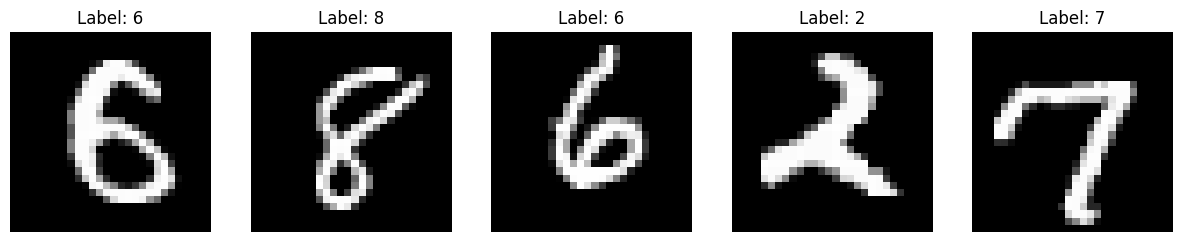

In [5]:
import matplotlib.pyplot as plt

# Display some images from the dataset
def show_images(images, labels, nrows=1, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].view(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
for images, labels in train_loader:
    show_images(images, labels)
    break

In [7]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten before fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 20

# Create DataLoader for training and testing datasets (assumed)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the CNN model
model = CNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

# Training the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store the average training loss for the epoch
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

# Testing the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")


Epoch 1/20, Loss: 0.8080099511284607
Epoch 2/20, Loss: 0.16965334762792333
Epoch 3/20, Loss: 0.09656743679534846
Epoch 4/20, Loss: 0.06340022416995131
Epoch 5/20, Loss: 0.040437575440743
Epoch 6/20, Loss: 0.028997994935852825
Epoch 7/20, Loss: 0.0215172850010439
Epoch 8/20, Loss: 0.023539109667409776
Epoch 9/20, Loss: 0.021705404350898762
Epoch 10/20, Loss: 0.014375014684304415
Epoch 11/20, Loss: 0.00498950664306334
Epoch 12/20, Loss: 0.005173280040253303
Epoch 13/20, Loss: 0.014079867119424529
Epoch 14/20, Loss: 0.02177940867275207
Epoch 15/20, Loss: 0.011261485262942902
Epoch 16/20, Loss: 0.004926373731716315
Epoch 17/20, Loss: 0.0076085406401852525
Epoch 18/20, Loss: 0.013263279750233302
Epoch 19/20, Loss: 0.008649969598388508
Epoch 20/20, Loss: 0.012207659709046087
Accuracy on the test set: 98.04%


In [8]:
torch.save(model.state_dict(), 'cnn_model.pth')

In [11]:
from PIL import Image
# Load the saved model
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))
model.to(device)
model.eval()

new_image_path = '/content/neuf.png'
new_image = Image.open(new_image_path).convert("L")

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

new_image = transform(new_image)
new_image = new_image.unsqueeze(0)

with torch.no_grad():
    new_image = new_image.to(device)
    outputs = model(new_image)
    _, predicted_class = torch.max(outputs, 1)

print(f"Predicted Class: {predicted_class.item()}")


Predicted Class: 9
